# Different collection

## Load and download data

In [1]:
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/different_collection/first_four.zip -o first_four.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 17 27.7M   17 4974k    0     0  7719k      0  0:00:03 --:--:--  0:00:03 7736k
100 27.7M  100 27.7M    0     0  23.3M      0  0:00:01  0:00:01 --:--:-- 23.4M


In [2]:
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/different_collection/remainder.zip -o remainder.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1  224M    1 2782k    0     0  7785k      0  0:00:29 --:--:--  0:00:29 7816k
 13  224M   13 30.1M    0     0  21.2M      0  0:00:10  0:00:01  0:00:09 21.3M
 25  224M   25 57.6M    0     0  24.4M      0  0:00:09  0:00:02  0:00:07 24.4M
 40  224M   40 91.9M    0     0  26.7M      0  0:00:08  0:00:03  0:00:05 26.7M
 43  224M   43 97.1M    0     0  19.7M      0  0:00:11  0:00:04  0:00:07 19.7M
 55  224M   55  125M    0     0  23.3M      0  0:00:09  0:00:05  0:00:04 24.4M
 88  224M   88  198M    0     0  31.1M      0  0:00:07  0:00:06  0:00:01 33.9M
100  224M  100  224M    0     0  32.6M      0  0:00:06  0:00:06 --:--:-- 36.9M


In [3]:
!unzip -nq first_four.zip

In [4]:
!unzip -nq remainder.zip

## Problem statement

The test dataset used in Lab 2 came from three different data collection sessions, as indicated by their filenames. How well can we determine which data collection session the images came from, if we only consider the first four images from each session?

Dataloading code has been prepared in advance below to save you time.

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from pathlib import Path

class ClassCustomDataset(torch.utils.data.Dataset):
    def __init__(self, loaddir):
        self.loaddir = Path(loaddir)
        self.X = sorted(self.loaddir.glob("*.png"))

        class_conversion = {"A": 0, "B": 1, "C": 2, "D": 3}
        self.y = [class_conversion.get(i.name[5]) for i in self.X]
        self.transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.ConvertImageDtype(torch.float32),
                torchvision.transforms.Resize(size=(256, 256)),
                torchvision.transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    def __getitem__(self, idx):
        X = torchvision.io.decode_image(self.X[idx], mode="RGB")
        X = self.transforms(X)
        return X, self.y[idx]

    def __len__(self):
        return len(self.X)

train_dataset = ClassCustomDataset("first_four")
test_dataset = ClassCustomDataset("remainder")
```

You are prohibited to use labels from the `remainder/` folder for any form of model training. You can only use labels from `remainder/` for visualization purposes and also to calculate classification performance.

Here is how your work will be scored:

- Your work will be scored by taking your F1 score minus 0.6, then multipled by ten. If your F1 score is less than 0.6, then no points will be granted. Examples below:
    - 0.50 F1 score = 0 pts
    - 0.60 F1 score = 0 pts
    - 0.67 F1 score = 0.7 pts
    - 0.72 F1 score = 1.2 pts
    - 0.85 F1 score = 2.5 pts
    - 0.95 F1 score = 3.5 pts
    - 1.0 F1 score = 4.0 pts
- Scoring will be through notebook submission only to keep things simple, no API submission involved. Thus, please clearly print out your score in your notebook!
- Make sure that your notebook can reproduce your results. Small variations due to stochasticity are acceptable. If your notebook has a missing chunk of code in the middle and suddenly ends with perfect 1.0 F1 score, I cannot grant you the full 4 points as I cannot reproduce your results!
- F1 score calculation will need to be accurate! If your F1 score calculation is strange and I arrive at a significantly different F1 score during grading, I will use the number I calculated instead of the reported number.

## Your work below

In [5]:
# Read everything clearly before you start!
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from pathlib import Path

class ClassCustomDataset(torch.utils.data.Dataset):
    def __init__(self, loaddir):
        self.loaddir = Path(loaddir)
        self.X = sorted(self.loaddir.glob("*.png"))

        class_conversion = {"A": 0, "B": 1, "C": 2}
        self.y = [class_conversion.get(i.name[5]) for i in self.X]
        self.transforms = torchvision.transforms.Compose(
            [
                # torchvision.transforms.ConvertImageDtype(torch.float32),
                torchvision.transforms.Resize(size=(256, 256)),
                # torchvision.transforms.Normalize(
                #     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                # ),
            ]
        )

    def __getitem__(self, idx):
        X = torchvision.io.decode_image(self.X[idx], mode="RGB")
        X = self.transforms(X)
        return X, self.y[idx]

    def __len__(self):
        return len(self.X)

train_dataset = ClassCustomDataset("first_four")
test_dataset = ClassCustomDataset("remainder")

---

In [6]:
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import f1_score
from PIL import Image

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
train_images = torch.stack([train_dataset[idx][0] for idx in range(len(train_dataset))])
train_labels = torch.tensor([train_dataset[idx][1] for idx in range(len(train_dataset))])
train_images.shape, train_labels.shape

(torch.Size([12, 3, 256, 256]), torch.Size([12]))

In [9]:
test_dataloader = DataLoader(test_dataset, batch_size=16)
len(test_dataset)

174

In [10]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval();

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
def get_prototypes(images, labels):
    class_embs = {}
    inputs = processor(images=images.to(device), return_tensors="pt").to(device)
    
    with torch.no_grad():
        feats = model.get_image_features(**inputs)

    for feat, label in zip(feats, labels):
        class_embs.setdefault(label.item(), []).append(feat)
    
    for k in class_embs.keys():
        class_embs[k] = torch.stack(class_embs[k]).mean(dim=0)  # Average embeddings to get prototypes
    return torch.stack([F.normalize(class_embs[k], dim=0) for k in sorted(class_embs)]) 

In [12]:
prototypes = get_prototypes(train_images, train_labels)
prototypes.shape

torch.Size([3, 512])

In [13]:
def make_predictions(prototypes, test_dataloader):
    all_logits = []
    all_preds = []
    all_labels = []
    
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        inputs = processor(images=images, return_tensors="pt").to(device)
    
        with torch.no_grad():
            test_embs = model.get_image_features(**inputs)
            test_embs = F.normalize(test_embs, dim=1)
            
            logits = test_embs @ prototypes.T  # Cosine similarity
            preds = logits.argmax(dim=1)
    
        all_logits.extend(logits.cpu().tolist())
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
    
    return all_logits, all_preds, all_labels

In [14]:
all_logits, all_preds, all_labels = make_predictions(prototypes, test_dataloader)

In [15]:
f1_score(all_preds, all_labels, average="macro")

0.9113225276015974

In [16]:
wrong_indices = []
for idx, (logits, pred, label) in enumerate(zip(all_logits, all_preds, all_labels)):
    if pred != label:
        print(f"{idx}\tProbs: {max(logits)}\tPredicted: {pred}\tActual: {label}")
        wrong_indices.append(idx)
wrong_indices, len(wrong_indices)

125	Probs: 0.9477155804634094	Predicted: 0	Actual: 1
136	Probs: 0.9386997818946838	Predicted: 0	Actual: 1
137	Probs: 0.8943066000938416	Predicted: 0	Actual: 1
140	Probs: 0.9252341985702515	Predicted: 0	Actual: 1
141	Probs: 0.8747471570968628	Predicted: 0	Actual: 1
144	Probs: 0.952846884727478	Predicted: 0	Actual: 1
145	Probs: 0.9275234341621399	Predicted: 0	Actual: 1
146	Probs: 0.8925274014472961	Predicted: 0	Actual: 1
147	Probs: 0.9009097814559937	Predicted: 0	Actual: 1
148	Probs: 0.9138075113296509	Predicted: 0	Actual: 1


([125, 136, 137, 140, 141, 144, 145, 146, 147, 148], 10)

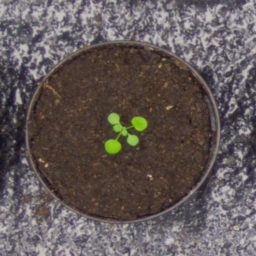

In [17]:
sample_idx = wrong_indices[0]
Image.fromarray(test_dataset[sample_idx][0].permute(1, 2, 0).cpu().numpy())

## Pseudo-labeling

In [18]:
threshold = 0.90
confident_indices = []
for idx, logits in enumerate(all_logits):
    if max(logits) >= threshold:
        confident_indices.append(idx)
len(confident_indices)

167

In [19]:
confident_images = torch.stack([test_dataset[idx][0] for idx in confident_indices])
confident_labels = torch.tensor([test_dataset[idx][1] for idx in confident_indices])
confident_images.shape, confident_labels.shape

(torch.Size([167, 3, 256, 256]), torch.Size([167]))

In [20]:
pseudo_train_images = torch.cat([train_images, confident_images])
pseudo_train_labels = torch.cat([train_labels, confident_labels])
pseudo_train_images.shape, pseudo_train_labels.shape

(torch.Size([179, 3, 256, 256]), torch.Size([179]))

In [21]:
pseudo_prototypes = get_prototypes(pseudo_train_images, pseudo_train_labels)
pseudo_prototypes.shape

torch.Size([3, 512])

In [22]:
pseudo_all_logits, pseudo_all_preds, pseudo_all_labels = make_predictions(pseudo_prototypes, test_dataloader)

In [23]:
f1_score(pseudo_all_preds, pseudo_all_labels, average="macro")

0.9845128205128205